# The Bayesian Linear Regression Model

This notebook cntains code to the accompanying PDF file available here on Github:

[Bayesian Linear Regression Model Tutorial](https://github.com/djlacombe/Bayesian-Regression-Tutorial)

The notebook only requires a basic Python environment and should work with any version of Python 3 and the related packages.

The first thing we need to do is to import the required Python packages:

In [1]:
import numpy as np

import math

from scipy.stats import multivariate_normal

from scipy.stats import chi2

from scipy.stats import norm

import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd


The estimation of the Bayesian linear regression model requires a dataset consisting of a **dependent** variable and one or more **independent** or **explanatory** variables. Instead of simply importing a dataset, the following code will create so-called **fake** data. The reason for simulating a dataset is that we can set the coefficients of the model, the number of observations, and the error variance, i.e. $\sigma^2$. Our Bayesian estimation routine should give us the same results are the simulated parameters. Simulating data in this manner ensures that our code is working because we know the "ground truth" values of our parameters.

First, we set the number of observations in our data and the number of explanatory variables, exculding the constant.

In [2]:
n = 500    # Number of observations

k = 2       # Number of explanatory variables, excluding the constant

Next, we create the intercept term (an $n \times 1$) column vector of ones, as well as the matrix of explanatory variables of size $n \times k$. Then, we put all of this into a new matrix $x$.

In [3]:
intercept = np.ones((n,1))  # Intercept term

explanatory = norm.rvs(0,1, size = (n,k))   # Matrix of explanatory variables N(0,1)

x = np.hstack([intercept, explanatory]) # Place the intecept and explanatory variables in one big matrix

Let's check the shape of the intercept and explanatory variable matrix:

In [4]:
print(f'Intercept size:',intercept.shape)
print(f'Explanatory variable matrix size:',explanatory.shape)
print(f'Size of the combined x matrix:',x.shape)

Intercept size: (500, 1)
Explanatory variable matrix size: (500, 2)
Size of the combined x matrix: (500, 3)


Next, we set the value of our coefficinets or $\beta$'s in out regression model. This can be any real value, but we choose 3 in this exercise. 

In [5]:
beta = 3.0*np.ones((k+1,1))   # Set all coefficients (including constant) to 3.


The linear regression model has the following mathematical form:

$y = X\beta + \varepsilon$

Therefore, we have to calcualte the dot product between $X$ and $\beta$ in the following code block.

In [6]:
temp = x@beta   # Dot product between X and beta. Note that the @ sign is shorthand for the dot prduct.


We have to choose a values for the error variance, and in the next code block we set it to 0.5, which is a relatively small value. You can think of the error variance as the amount of "spread" of the data around the regression line.

In [7]:
error = norm.rvs(loc = 0,scale = 1, size = (n,1)) # Error term

We can now set a custom value for $\sigma^2$, which in our case will be 0.5 in this simulated dataset. Note that if we use a larger value (e.g., 10) that indicates that the data are more widely dispursed around the estimated regression line.

In [8]:
error = error*math.sqrt(0.5)

Finally, we can create our **dependent variable** by adding the dot product between $X$ and $\beta$ to the error term that we just created.

In [9]:
y = temp + error    # Our simulated dataset


We now have a dataset that can be used to generate the coefficients in our linear regression model via ordinary least squares (OLS), maximum likelihood (ML), or any other method. Since this tutorial is interested in the Bayesian paradigm, we now direct our attention to the Gibbs sampling algorithm.

This example will use diffuse priors in the Gibbs sampling algorithm.

The Gibbs sampler is an iterative method, which goes back and forth drawing random samples from the conditional distributions. We can control the number of Gibbs samples in our algorithm, making note of the fact that the more one samples, the more compute time that will be required. Another quantity that we need to set is the number of burn-in samples. The burn-in samples are the number of samples we discard after sampling begins in order for the Gibbs sampling algorithm to begin draing from the appropriate stationary distribution.

The number of burn-in samples is arbitrary and the Bayesian linear regresion model doesn't need many burn in samples to begin sampling from the appropriate stationary distribution.

Note that this is just a demonstration that illustrates the drawing process. Later on, we will place this code in a loop equal to the number of draws we wish to take.

In [10]:
gibbs_samples = 1100   # Number of Gibbs samples

burn_in = 100          # Number of burn-in samples

The next code block sets up some storage vectors for our Gibbs samples: one vector for the Gibbs samples of the coefficeints and another one for the Gibbs samples of the error variance.

In [11]:
beta_store = np.zeros((n,k+1), dtype=float)   # Empty matrix to store draws for betas
sigma_store = np.zeros((n,1), dtype=float)    # Empty vector to store draws for sigma

Now, we need to decide from which conditional distribution to sample from first. It doesn't matter which conditional distribution we start with, but we do need to initialize values for the parameter(s) we are not sampling from.

For example, if we start with the draws for betas, we need to have a starting value for the $\sigma$ parameter.

Let's start with an example draw for the $\beta$'s in the next code block. Remember that the conditional distribution for $\beta$ will be a random draw from a multivariate normal distribution.

In [12]:
sigma = 0.5

# Draw for beta
covariance = np.linalg.inv(x.T@x)*sigma**2 # This is the covariance matrix for beta for the MVN draw. Notice sigma in formula.

mean = np.linalg.inv(x.T@x)@(x.T@y) # This is the mean that we need for the MVN draw
    
beta = multivariate_normal.rvs(mean.reshape(k+1), covariance,1) # Take MNV random draw

beta_store[1] = beta


Let's take a look at the first five rows of the variable beta_store. You'll notice that we have taken a random draw from the multivariate normal distribution with mean and covariance defined in the previous block.

The values that you see in the first row will be close to the value of the coefficients that we used in our simulated dataset. In our case, this was the value 3 and it appears that our draws for the $\beta$'s is extremely close!

In [13]:
beta_store[1:5,:]   # These draws are being stored in the matrix we preallocated earlier.

array([[2.94499805, 3.00548321, 2.99974318],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

Next, we will perform a random draw from the inverse Gamma distribution. There are many ways in which to take draws from the inverse gamma distribution and this method uses the non-central $\chi^2$ method:


In [14]:
# Draw for sigma
e = y - x@beta.reshape(-1,1)

shape = float(np.dot(e.T,e))

chi = chi2.rvs(n,1)

sigma = (shape/chi) # Take inverse gamma draw using chi2 trick

sigma_store[1] = sigma


We can now examine the first 5 elements of the stored sigma draws. Depending on your value of sigma, the first element should be close to the value that you used for the error variance when creating your simulated data.

In [15]:
sigma_store[1:5]

array([[0.493046],
       [0.      ],
       [0.      ],
       [0.      ]])

Now that we have all of the elements as individual cells, we can now combine these into one cell that will perform the Gibbs sampling algorithm.

In [16]:

import numpy as np

import math

from scipy.stats import multivariate_normal

from scipy.stats import chi2

from scipy.stats import norm

import seaborn as sns



n = 1000   # Number of observations

k = 2       # Number of explanatory variables, excluding the constant

intercept = np.ones((n,1))  # Intercept term

explanatory = norm.rvs(loc=0,scale=1, size = (n,k))   # Matrix of explanatory variables N(0,1)

x = np.hstack([intercept, explanatory]) # Place the intecept and explanatory variables in one big matrix

beta = 3*np.ones((k+1,1))   # Set all coefficients (including constant) to 3.

temp = x@beta   # Dot product between X and beta. Note that the @ sign is shorthand for the dot prduct.

error = norm.rvs(loc = 0,scale = 1, size = (n,1)) # Error term

error = error*math.sqrt(0.5) # Error # The error variance is given by scale

y = temp + error    # Our simulated dataset


gibbs_samples = 11000  # Number of Gibbs samples

burn_in = 1000    # Number of burn-in samples

beta_store = np.zeros((gibbs_samples-burn_in,k+1), dtype=float)   # Empty matrix to store draws for betas

sigma_store = np.zeros((gibbs_samples-burn_in,1), dtype=float)    # Empty vector to store draws for sigma

sigma = 0.5   # Initalize sigma to a random value

for i in range(gibbs_samples):
    
    # Draw for beta
    covariance = np.linalg.inv(x.T@x)*sigma**2 # This is the covariance matrix for beta for the MVN draw. Notice sigma in formula.

    mean = np.linalg.inv(x.T@x)@(x.T@y) # This is the mean that we need for the MVN draw
    
    beta = multivariate_normal.rvs(mean.reshape(k+1), covariance,1) # Take MNV random draw for the betas.

    # Draw for sigma
    e = y - x@beta.reshape(-1,1)

    shape = float(np.dot(e.T,e))

    chi = chi2.rvs(n,1)

    sigma = (shape/chi) # Take inverse gamma draw using chi2 trick

    if i >= burn_in:
        beta_store[i-burn_in] = beta
        sigma_store[i-burn_in] = sigma



Examining the matrix beta_store (where the draws from the Gibbs sampler are stored) shows us the following matrix, which is size gibbs_samples-burn_in. Note that the matrix values are close to our simulated coefficients of 3:

In [17]:
beta_store

array([[2.98494248, 3.03113413, 2.98667351],
       [2.97824533, 3.02831674, 3.01341144],
       [2.99598921, 3.02338165, 2.97951612],
       ...,
       [3.02461902, 3.03098619, 3.03361925],
       [2.98829373, 3.03228327, 2.97709471],
       [2.99428942, 3.0137118 , 3.00697699]])

The vector sigma_score store the values of the draws for our error variance, $\sigma$. Not that these values are also close to the simulated error variance of 0.5:

In [18]:
sigma_store

array([[0.45202752],
       [0.4590646 ],
       [0.44811089],
       ...,
       [0.49077685],
       [0.46680423],
       [0.50969225]])

Let's put the gibbs samples for the $\beta$'s and $\sigma^2$ into a dataframe for convenience:

In [19]:
gibbs_draws = pd.DataFrame({'constant': beta_store[:, 0], 'beta1': beta_store[:, 1], 'beta2': beta_store[:, 2], 'sigma^2': sigma_store[:, 0]})

We can now use all of the features of Pandas to calculate any quantity of interest. For example, we can calculate the mean of all of our parameters to see how close we are to their true values:

In [20]:
gibbs_draws.mean()

constant    2.991438
beta1       3.026612
beta2       2.998269
sigma^2     0.494960
dtype: float64

Usually in a Bayesian analysis, we report the mean of the Gibbs samples as the point estiamte and the lower and upper 95% interval around that mean, callled the credible interval. The next block of code examines these quantities:

In [21]:
data = np.array([gibbs_draws.mean(), gibbs_draws.quantile(0.25), gibbs_draws.quantile(0.975)])  
credible_interval = pd.DataFrame(data.T)
credible_interval.index = ['constant','beta1','beta2','sigma^2']
credible_interval.columns = ['Mean','Lower 95%','Upper95%']


In [22]:
credible_interval

,Mean,Lower 95%,Upper95%
constant,2.991438,2.980919,3.022740
beta1,3.026612,3.016069,3.057731
beta2,2.998269,2.987677,3.029204
sigma^2,0.494960,0.479881,0.540110


We can also produce trace plots of the Gibbs samples for all of our parameter estimates:

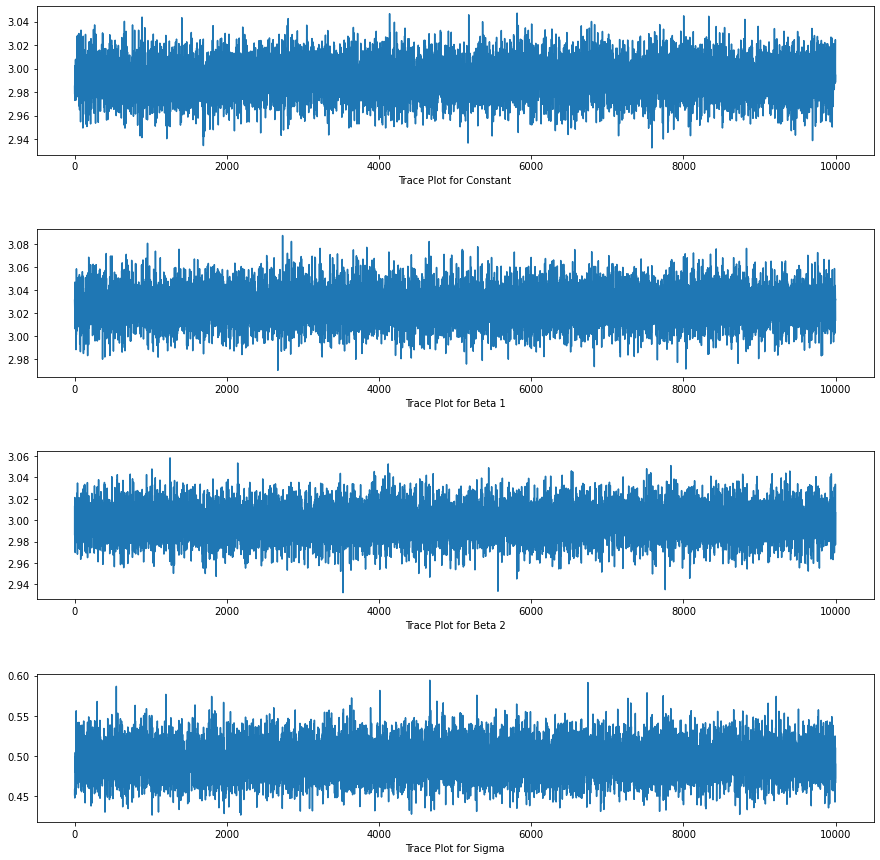

In [45]:
fig, axs = plt.subplots(4,figsize=(15,15))
axs[0].plot(gibbs_draws['constant'])
axs[0].set_xlabel('Trace Plot for Constant')
axs[1].plot(gibbs_draws['beta1'])
axs[1].set_xlabel('Trace Plot for Beta 1')
axs[2].plot(gibbs_draws['beta2'])
axs[2].set_xlabel('Trace Plot for Beta 2')
axs[3].plot(gibbs_draws['sigma^2'])
axs[3].set_xlabel('Trace Plot for Sigma')
plt.subplots_adjust(hspace=0.5)
plt.show()

We can also produce histograms with kernel density plots for the parameters as well. Here is a demonstration using the coefficient, $\beta_1$ 

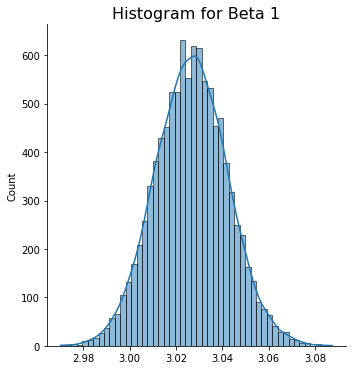

In [38]:
sns.displot(beta_store[:,1], bins = 50 , kde=True)
plt.title('Histogram for Beta 1', fontsize=16)
plt.show()

We hope that this tutorial has demystified the mathematics and code surrounding the Bayesian estimation of the linear regression model.

# Exercises

+ Modify the number of observations (n) used in the data creation section of the code.
+ Modify the number of Gibbs samples and burn in, making sure that the number of Gibbs samples is larger that the number of burn-in.
+ Modify the values of the coefficients for the $\beta$'s and $\sigma^2$
+ Modify the code to allow for proper prior information in the model.
+ Plot the marginal distributions for each parameter using Seaborn.